http://mlg.eng.cam.ac.uk/teaching/4f13/1920/bayesian%20finite%20regression.pdf (Last slide)
http://mlg.eng.cam.ac.uk/teaching/4f13/1920/marginal%20likelihood.pdf

In [144]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', size=14)
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
from time import time

### Pseudo-random data (degree 3 polynomial)

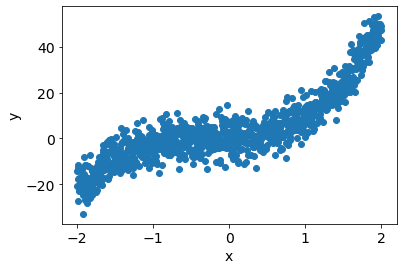

In [145]:
np.random.seed(0)

N = 1000
sigma_n = 5 # noise in data
sigma_w = 100 # parameter variance

x = np.linspace(-2,2,N).reshape(-1,1)
f_x = 4*x**3 + 3*x**2 + 2*x + 1
epsilon = np.random.normal(loc=0, scale=sigma_n, size=N).reshape(-1,1)
y = f_x + epsilon

plt.scatter(x, y);
plt.xlabel('x');plt.ylabel('y');

### Marginal likelihood pdf

In [146]:
def LogMarginalLikelihoodPdf(x, y):
    return np.log(scipy.stats.multivariate_normal.pdf(y.squeeze(), np.zeros(N), (x@x.T)*sigma_w**2 + np.eye(N)*sigma_n**2))

### Models

In [147]:
x_M0 = x.copy()
x_M1 = np.hstack([np.ones((N,1)), x])
x_M2 = np.hstack([np.ones((N,1)), x, x**2])
x_M3 = np.hstack([np.ones((N,1)), x, x**2, x**3])
x_M4 = np.hstack([np.ones((N,1)), x, x**2, x**3, x**4])
x_M5 = np.hstack([np.ones((N,1)), x, x**2, x**3, x**4, x**5])
x_M6 = np.hstack([np.ones((N,1)), x, x**2, x**3, x**4, x**5, x**6])
x_M7 = np.hstack([np.ones((N,1)), x, x**2, x**3, x**4, x**5, x**6, x**7])

### Model selection

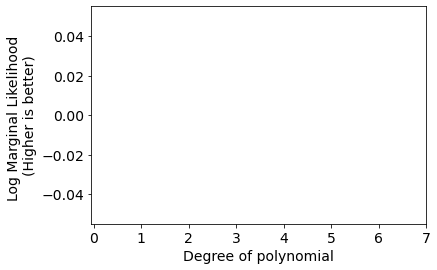

In [148]:
scores = [LogMarginalLikelihoodPdf(x_M, y) for x_M in [x_M0, x_M1, x_M2, x_M3, x_M4, x_M5, x_M6, x_M7]]
plt.plot(scores);
plt.xlabel('Degree of polynomial');
plt.ylabel('Log Marginal Likelihood \n(Higher is better)');
plt.xticks(range(len(scores)));

### Model selection with parameter optimization

In [158]:
def NegLogMarginalLikelihoodPdf(params, x, y): # Negative log marginal likelihood (written in GP fashion)
    sigma_n, sigma_w = params
    K = (x@x.T)*sigma_w**2 + np.eye(N)*sigma_n**2
    K_inv = np.linalg.pinv(K)
    nll = 0.5*y.T@K_inv@y + 0.5*np.log(np.linalg.det(K)) + (len(y)/2)*np.log(2*np.pi)
    print(K)
    print(0.5*y.T@K_inv@y, 0.5*np.log(np.linalg.det(K)), (len(y)/2)*np.log(2*np.pi))
    return nll[0,0]

In [159]:
NegLogMarginalLikelihoodPdf((0.01, 0.01), x_M1, y)

[[ 0.0006     0.0004992  0.0004984 ... -0.0002984 -0.0002992 -0.0003   ]
 [ 0.0004992  0.0005984  0.0004976 ... -0.0002976 -0.0002984 -0.0002992]
 [ 0.0004984  0.0004976  0.0005968 ... -0.0002968 -0.0002976 -0.0002984]
 ...
 [-0.0002984 -0.0002976 -0.0002968 ...  0.0005968  0.0004976  0.0004984]
 [-0.0002992 -0.0002984 -0.0002976 ...  0.0004976  0.0005984  0.0004992]
 [-0.0003    -0.0002992 -0.0002984 ...  0.0004984  0.0004992  0.0006   ]]
[[3.24032436e+08]] -inf 918.9385332046727


-inf

degree = 0, sigma_w=10.0, sig_n_opt=10.0 time: 0.5179195404052734 seconds
degree = 1, sigma_w=10.0, sig_n_opt=10.0 time: 0.5073156356811523 seconds
degree = 2, sigma_w=10.0, sig_n_opt=10.0 time: 0.510296106338501 seconds
degree = 3, sigma_w=10.0, sig_n_opt=10.0 time: 0.5096111297607422 seconds
degree = 4, sigma_w=10.0, sig_n_opt=10.0 time: 0.5116767883300781 seconds
degree = 5, sigma_w=10.0, sig_n_opt=10.0 time: 0.5100688934326172 seconds
degree = 6, sigma_w=10.0, sig_n_opt=10.0 time: 0.5097932815551758 seconds
degree = 7, sigma_w=10.0, sig_n_opt=10.0 time: 0.5098989009857178 seconds


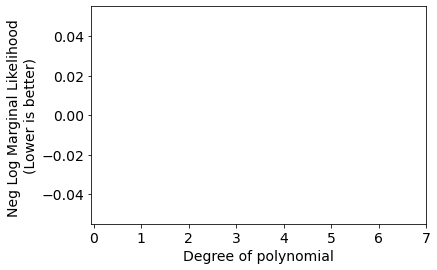

In [151]:
Negscores = []
sig_n_list = []
sig_w_list = []
sig_w = 10
sig_n = 10
for i, x_M in enumerate([x_M0, x_M1, x_M2, x_M3, x_M4, x_M5, x_M6, x_M7]):
    init = time()
    result = minimize(fun=NegLogMarginalLikelihoodPdf, x0=(sig_n, sig_w), args=(x_M, y))
    sig_n_opt, sig_w_opt = result.x
    sig_n_list.append(sig_n_opt)
    sig_w_list.append(sig_w_opt)
    print(f'degree = {i}, sigma_w={sig_w_opt}, sig_n_opt={sig_n_opt}', 'time:',time()-init,'seconds')
    Negscores.append(NegLogMarginalLikelihoodPdf((sig_n_opt, sig_w_opt), x_M, y))
plt.plot(Negscores);
plt.xlabel('Degree of polynomial');
plt.ylabel('Neg Log Marginal Likelihood \n(Lower is better)');
plt.xticks(range(len(Negscores)));

## Using empirical bayes (Bishop)

In [138]:
alpha = 1/sigma_w**2
beta = 1/sigma_n**2

### Marginal likelihood pdf

In [139]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape

    m_N, _, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)
    
    E_D = beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = alpha * np.sum(m_N ** 2)
    
    score = M * np.log(alpha) + \
            N * np.log(beta) - \
            E_D - \
            E_W - \
            np.log(np.linalg.det(S_N_inv)) - \
            N * np.log(2 * np.pi)

    return 0.5 * score

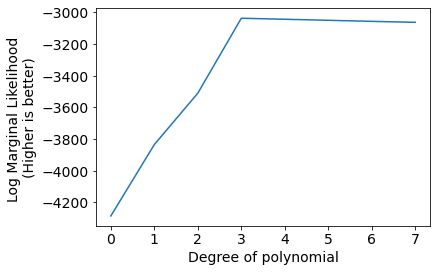

In [140]:
Bscores = [log_marginal_likelihood(x_M, y, alpha, beta) for x_M in [x_M0, x_M1, x_M2, x_M3, x_M4, x_M5, x_M6, x_M7]]
plt.plot(Bscores);
plt.xlabel('Degree of polynomial');
plt.ylabel('Log Marginal Likelihood \n(Higher is better)');
plt.xticks(range(len(Bscores)));

In [141]:
list(zip(scores, Bscores))

[(-inf, -4285.261000670051),
 (-inf, -3834.413976828204),
 (-inf, -3510.198243296033),
 (-inf, -3037.1015706006956),
 (-inf, -3043.478864663047),
 (-inf, -3050.110011419756),
 (-inf, -3056.7609228930273),
 (-inf, -3062.8368316800147)]

### Paramater tuning

In [142]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.
        
    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """
    
    N, M = Phi.shape

    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N ** 2)

        beta_inv = 1 / (N - gamma) * np.sum((t - Phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N

    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    return alpha, beta, m_N, S_N

In [143]:
for i, x_M in enumerate([x_M0, x_M1, x_M2, x_M3, x_M4, x_M5, x_M6, x_M7]):
    init = time()
    alpha, beta, m_N, S_N = fit(x_M, y, rtol=1e-5, verbose=True)
    print('Degree',i,'sigma_w',1/np.sqrt(alpha),'sigma_n', 1/np.sqrt(beta))
    print('Degree',i,'sigma_w',sig_w_list[i],'sigma_n', sig_n_list[i], '(Earlier method)')
    print('time:',time()-init,'seconds')

Convergence after 3 iterations.
Degree 0 sigma_w 11.593101703465186 sigma_n 9.35958176227756
Degree 0 sigma_w 67.36247360447825 sigma_n 1.3811964410207875 (Earlier method)
time: 0.0030295848846435547 seconds
Convergence after 3 iterations.
Degree 1 sigma_w 8.866800803457197 sigma_n 8.048529569003309
Degree 1 sigma_w 57.77850385431284 sigma_n 1.398290540690322 (Earlier method)
time: 0.004939556121826172 seconds
Convergence after 2 iterations.
Degree 2 sigma_w 6.9778422692478985 sigma_n 6.946352976189561
Degree 2 sigma_w 48.45758776603595 sigma_n 1.3826104295324149 (Earlier method)
time: 0.0033392906188964844 seconds
Convergence after 4 iterations.
Degree 3 sigma_w 2.812513466859813 sigma_n 4.9210563801447975
Degree 3 sigma_w 14.724887028440621 sigma_n 1.3769721679510585 (Earlier method)
time: 0.002380847930908203 seconds
Convergence after 4 iterations.
Degree 4 sigma_w 2.4211372908556354 sigma_n 4.922121375564269
Degree 4 sigma_w 13.053851895378054 sigma_n 1.3768528001590439 (Earlier me

### Comparing two views of likelihoods

### \begin{align}
p(\theta, \sigma_w) &= \mathcal{N}(0, \sigma_w^2)\\
p(y|\theta, \sigma_n) &= \mathcal{N}(0, \sigma_n^2)

S_n = \left(\right)^{-1}
\end{align}

## Drawbacks

1. This method does not scale well with big data (while doing parameter optimization), because of matrix inversion.
    * Potential solution: optimize parameters with chepaer methods, then use Marginal likelihood for model selection